In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import seaborn as sns

In [2]:
# load dataset

df_all_cleaned = pd.read_csv(r'C:\Users\Asus\Downloads\df_all_cleaned.csv')
df_all_cleaned.head(3)

,Counter Name,Street Address,Hourly Count,Count Date and Time,Geo Coordinates,Month and Year of Count,Arrondisement,latitude,longitude,Date
0,97 avenue Denfert Rochereau SO-NE,97 AVENUE DENFERT ROCHEREAU,4,2023-09-01 03:00:00,"48.83504,2.33314",2023-09,14,48.83504,2.33314,2023-09-01
1,97 avenue Denfert Rochereau SO-NE,97 AVENUE DENFERT ROCHEREAU,63,2023-09-01 05:00:00,"48.83504,2.33314",2023-09,14,48.83504,2.33314,2023-09-01
2,97 avenue Denfert Rochereau SO-NE,97 AVENUE DENFERT ROCHEREAU,16,2023-09-01 04:00:00,"48.83504,2.33314",2023-09,14,48.83504,2.33314,2023-09-01


In [5]:
# check types
df_all_cleaned.dtypes

Counter Name                object
Street Address              object
Hourly Count                 int64
Count Date and Time         object
Geo Coordinates             object
Month and Year of Count     object
Arrondisement                int64
latitude                   float64
longitude                  float64
Date                        object
dtype: object

In [7]:
# convert to datetime
df_all_cleaned['Count Date and Time'] = pd.to_datetime(df_all_cleaned['Count Date and Time'])

In [9]:
# check that the period is right
earliest_date = pd.to_datetime(df_all_cleaned['Count Date and Time']).min()
print(earliest_date)

latest_date = pd.to_datetime(df_all_cleaned['Count Date and Time']).max()
print(latest_date)


2022-03-27 21:00:00
2024-10-07 21:00:00


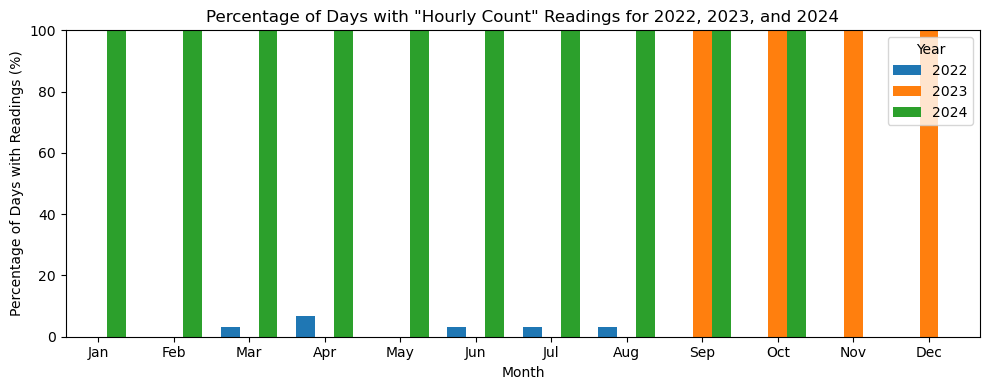

In [11]:
# Make empty dictionary to store the percentage data for each year
percentage_data = {}

# Loop through each year and calculate the percentage of days with readings per month
for year in [2022, 2023, 2024]:
    # Filter data for the specific year
    df_year =df_all_cleaned[df_all_cleaned['Count Date and Time'].dt.year == year]
    
    # Count unique days with readings for each month
    unique_days_with_data = df_year[df_year['Hourly Count'].notna()].groupby(df_year['Count Date and Time'].dt.month)['Count Date and Time'].nunique()
    
    # Get total days in each month of the year
    days_in_month = {month: calendar.monthrange(year, month)[1] for month in range(1, 13)}
    
    # Calculate the percentage of days with data
    percentage_days_with_data = (unique_days_with_data / pd.Series(days_in_month)) * 100
    
    # Fill missing months with 0% data availability
    percentage_days_with_data = percentage_days_with_data.reindex(range(1, 13), fill_value=0)

    # Store the data in the dictionary
    percentage_data[year] = percentage_days_with_data

# Convert the dictionary to a df for easy plotting
percentage_df = pd.DataFrame(percentage_data)

# Plot 
plt.figure(figsize=(10, 4))
bar_width = 0.25  # Width of each bar
months = range(1, 13)

# Create bars for each year
for i, year in enumerate([2022, 2023, 2024]):
    # Offset the bar positions for each year
    plt.bar(
        [m + i * bar_width for m in months],
        percentage_df[year],
        width=bar_width,
        label=str(year)
    )

# Set x-axis labels for each month
plt.xticks([m + bar_width for m in months], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


# Labels and title
plt.xlabel('Month')
plt.ylabel('Percentage of Days with Readings (%)')
plt.title('Percentage of Days with "Hourly Count" Readings for 2022, 2023, and 2024')
plt.ylim(0, 100)  # Limit y-axis to 100%
plt.legend(title="Year")

# Display it
plt.tight_layout()
plt.show()

In [13]:
# load dataset 

df_all_agg = pd.read_csv(r'C:\Users\Asus\Downloads\df_all_agg.csv')
df_all_agg.head(3)

,Counter Name,Date,Arrondisement,Daily Count
0,10 avenue de la Grande Armée SE-NO,2023-09-01,17,731
1,10 avenue de la Grande Armée SE-NO,2023-09-02,17,767
2,10 avenue de la Grande Armée SE-NO,2023-09-03,17,666


In [15]:
# Convert to datetime without time components
df_all_agg['Date'] = pd.to_datetime(df_all_agg['Date']).dt.normalize()


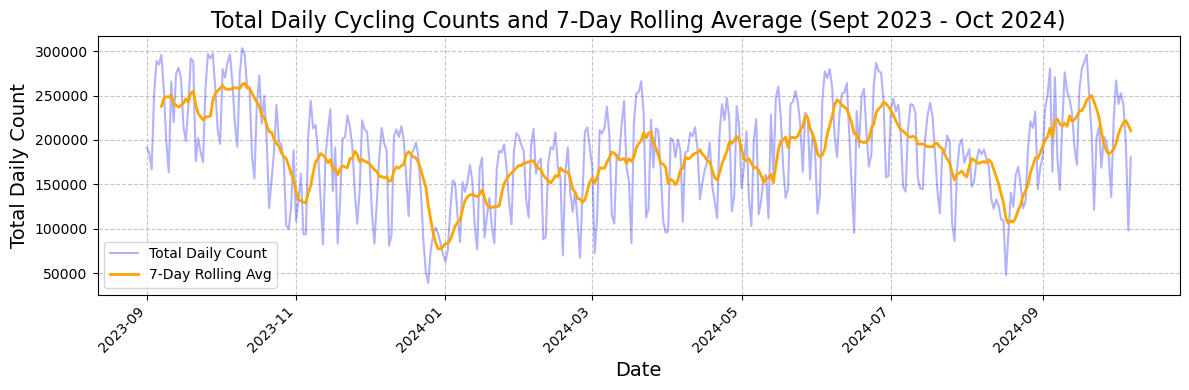

In [17]:
# Define start and end dates
start_date = pd.Timestamp('2023-09-01')
end_date = pd.Timestamp('2024-10-31')

# Filter df to that date range
df_filtered = df_all_agg[(df_all_agg['Date'] >= start_date) & (df_all_agg['Date'] <= end_date)]

# Group by date and calculate the total daily count across all counters
daily_totals_filtered = df_filtered.groupby('Date')['Daily Count'].sum().reset_index()

# Calculate 7-day rolling average
daily_totals_filtered['7_day_rolling_avg'] = daily_totals_filtered['Daily Count'].rolling(window=7).mean()

# Plot
plt.figure(figsize=(12, 4))

# Plot the total daily counts
sns.lineplot(data=daily_totals_filtered, x='Date', y='Daily Count', color='blue', label='Total Daily Count', alpha=0.3)

# Plot the 7-day rolling average
sns.lineplot(data=daily_totals_filtered, x='Date', y='7_day_rolling_avg', color='orange', label='7-Day Rolling Avg', linewidth=2)

# Set plot details
plt.title('Total Daily Cycling Counts and 7-Day Rolling Average (Sept 2023 - Oct 2024)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Daily Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()


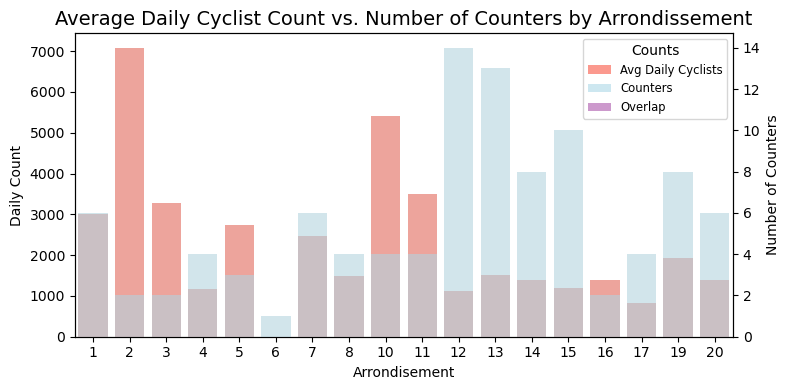

In [19]:
#Calculate average daily cyclist count per arrondissement
average_daily_counts = df_all_agg.groupby('Arrondisement')['Daily Count'].mean().reset_index()

#Calculate number of counters per arrondissement
counter_counts = df_all_agg.groupby('Arrondisement')['Counter Name'].nunique().reset_index()
counter_counts.rename(columns={'Counter Name': 'Counter Count'}, inplace=True)

#Merge the two dfs on arrondissement
merged_df = pd.merge(average_daily_counts, counter_counts, on='Arrondisement')

#Convert arrondissement to integer type
merged_df['Arrondisement'] = merged_df['Arrondisement'].astype(int)

# Sort by arrondissement in ascending order
merged_df = merged_df.sort_values('Arrondisement')

# Plot
plt.figure(figsize=(8, 4))

# Bar plot for average daily cyclist count
bar1 = sns.barplot(data=merged_df, x='Arrondisement', y='Daily Count', color='salmon', alpha=0.8, legend=False)  # Removed label

# Second y-axis for counter count
ax2 = plt.gca().twinx()
bar2 = sns.barplot(data=merged_df, x='Arrondisement', y='Counter Count', color='lightblue', alpha=0.6, ax=ax2, legend=False)  # Removed label


plt.title('Average Daily Cyclist Count vs. Number of Counters by Arrondissement', fontsize=14)
plt.xlabel('Arrondisement', fontsize=12)
plt.ylabel('Avg Daily Cyclist Count', fontsize=12)
ax2.set_ylabel('Number of Counters', fontsize=10)

# Customize x-ticks
plt.xticks(fontsize=10)

# Create patches for the legend
from matplotlib.patches import Patch
cyclist_patch = Patch(facecolor='salmon', alpha=0.8, label='Avg Daily Cyclists')
counter_patch = Patch(facecolor='lightblue', alpha=0.6, label='Counters')
overlap_patch = Patch(facecolor='purple', alpha=0.4, label='Overlap')

# Create single legend with all three colors
plt.legend(handles=[cyclist_patch, counter_patch, overlap_patch], 
          loc='upper right', 
          title='Counts', 
          fontsize='small')
plt.tight_layout()

plt.show()


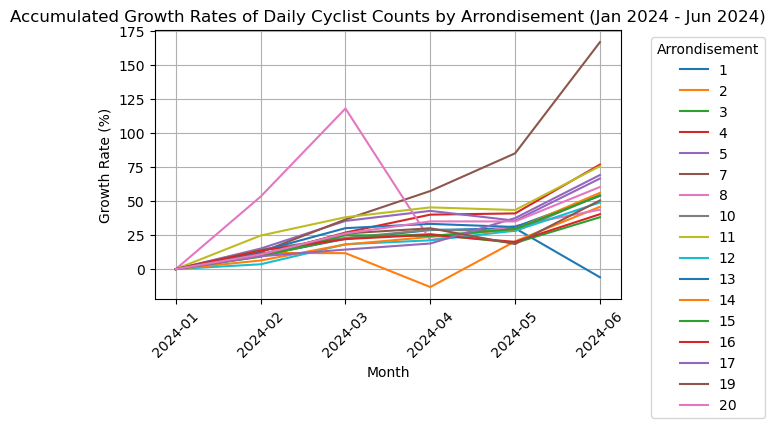

In [21]:
# Define start and end dates
start_date_2 = pd.Timestamp('2024-01-01')
end_date_2 = pd.Timestamp('2024-06-30')

# Filter df to desired time period
df_jantojune = df_all_agg[(df_all_agg['Date'] >= start_date_2) & (df_all_agg['Date'] <= end_date_2)]

# Group by arrond and date
daily_counts = df_jantojune.groupby(['Arrondisement', 'Date'])['Daily Count'].mean().reset_index()
daily_counts['Month'] = daily_counts['Date'].dt.to_period('M')

# Group by arrond and month
monthly_counts = daily_counts.groupby(['Arrondisement', 'Month'])['Daily Count'].mean().reset_index()

# Create pivot
pivot_counts = monthly_counts.pivot(index='Month', columns='Arrondisement', values='Daily Count')

# Calculate growth rates
growth_rates = ((pivot_counts - pivot_counts.iloc[0]) / pivot_counts.iloc[0] * 100)

# Plot
plt.figure(figsize=(7, 4))
for column in growth_rates.columns:
    plt.plot(growth_rates.index.astype(str), growth_rates[column], label=column)

plt.title('Accumulated Growth Rates of Daily Cyclist Counts by Arrondisement (Jan 2024 - Jun 2024)')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Arrondisement', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid() 
plt.show()

In [23]:
# Calculate total accumulated growth rate per arrondissement

total_growth = ((pivot_counts.iloc[-1] - pivot_counts.iloc[0]) / pivot_counts.iloc[0] * 100)
print("Total Accumulated Growth Rate by Arrondissement (Jan-Jun 2024):")
print(total_growth.sort_values(ascending=False))


Total Accumulated Growth Rate by Arrondissement (Jan-Jun 2024):
Arrondisement
7     166.855059
4      76.831400
11     75.686591
17     69.168885
5      66.589824
20     60.344666
14     56.056378
10     54.351388
15     54.126885
13     53.804672
19     50.506870
12     48.977134
2      45.793007
8      43.668951
16     40.356985
3      38.130416
1      -6.012742
dtype: float64


In [33]:
#  Calculate overall avg

overall_avg = total_growth.mean()
print(f"Overall average accumulated growth: {overall_avg:.1f}%")

Overall average accumulated growth: 58.5%


In [ ]:
### Olympics part ###

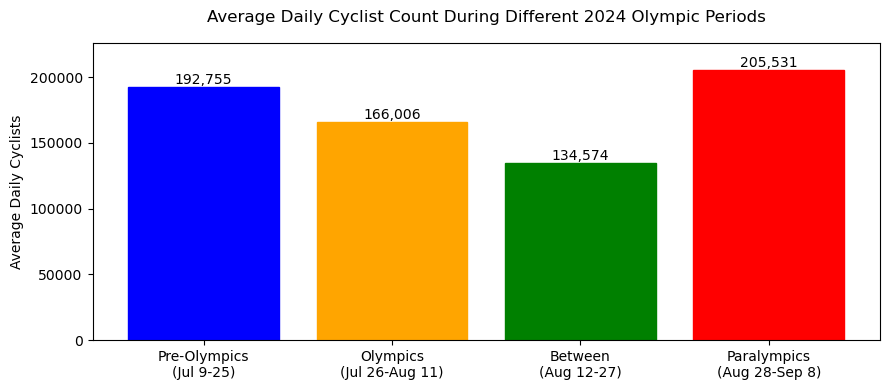

In [41]:
# Bar chart of avg daily cyclist counts

# Aggregate hourly counts to daily counts
df_daily = df_all_cleaned.groupby(df_all_cleaned['Count Date and Time'].dt.date)['Hourly Count'].sum().reset_index()
df_daily['Count Date and Time'] = pd.to_datetime(df_daily['Count Date and Time'])

# Define period ranges
pre_olympics_start = pd.to_datetime('2024-07-09')
pre_olympics_end = pd.to_datetime('2024-07-25')
olympics_start = pd.to_datetime('2024-07-26')
olympics_end = pd.to_datetime('2024-08-11')
between_start = pd.to_datetime('2024-08-12')
between_end = pd.to_datetime('2024-08-27')
paralympics_start = pd.to_datetime('2024-08-28')
paralympics_end = pd.to_datetime('2024-09-08')

# Calculate averages for each period
pre_olympics = df_daily[
    (df_daily['Count Date and Time'] >= pre_olympics_start) & 
    (df_daily['Count Date and Time'] <= pre_olympics_end)
]['Hourly Count'].mean()  # Now these are daily totals

olympics = df_daily[
    (df_daily['Count Date and Time'] >= olympics_start) & 
    (df_daily['Count Date and Time'] <= olympics_end)
]['Hourly Count'].mean()

between = df_daily[
    (df_daily['Count Date and Time'] >= between_start) & 
    (df_daily['Count Date and Time'] <= between_end)
]['Hourly Count'].mean()

paralympics = df_daily[
    (df_daily['Count Date and Time'] >= paralympics_start) & 
    (df_daily['Count Date and Time'] <= paralympics_end)
]['Hourly Count'].mean()

# Create visualization
periods = ['Pre-Olympics\n(Jul 9-25)', 'Olympics\n(Jul 26-Aug 11)', 
           'Between\n(Aug 12-27)', 'Paralympics\n(Aug 28-Sep 8)']
counts = [pre_olympics, olympics, between, paralympics]

# Create bar chart
plt.figure(figsize=(9, 4))
bars = plt.bar(periods, counts)

# Customize colors
colors = ['blue', 'orange', 'green', 'red']
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Add title and labels
plt.title('Average Daily Cyclist Count During Different 2024 Olympic Periods', pad=15)
plt.ylabel('Average Daily Cyclists')

# Customize y-axis
max_count = max(counts)
plt.ylim(0, max_count * 1.1)  # Add 10% padding on top

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

plt.tight_layout()

plt.show()


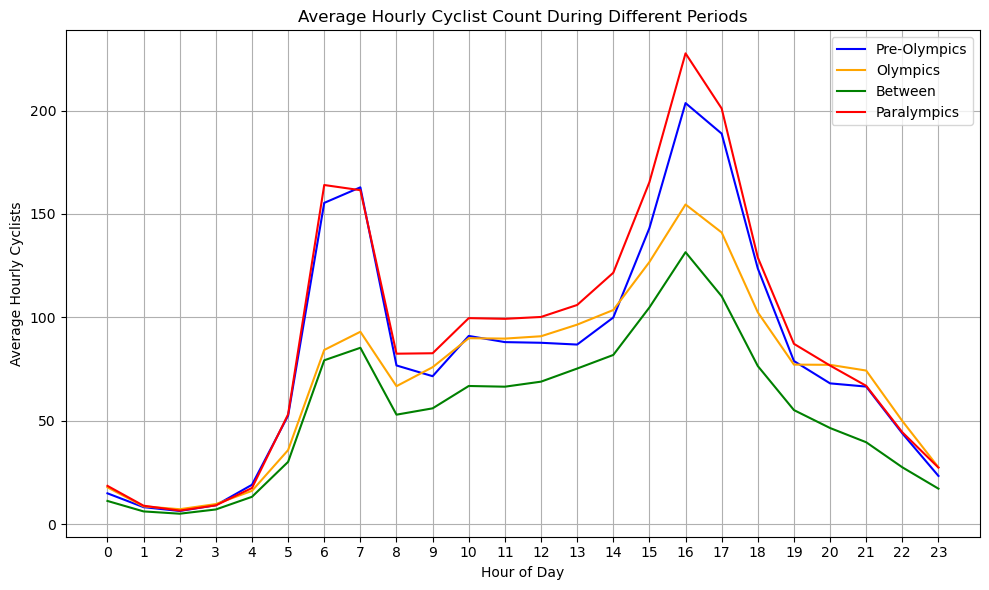

In [43]:
# Calculate average by hour for each period
def get_hourly_average(df, start_date, end_date):
    mask = (df['Count Date and Time'] >= start_date) & (df['Count Date and Time'] <= end_date)
    return df[mask].groupby(df[mask]['Count Date and Time'].dt.hour)['Hourly Count'].mean()

pre_olympics_avg = get_hourly_average(df_all_cleaned, pre_olympics_start, pre_olympics_end)
olympics_avg = get_hourly_average(df_all_cleaned, olympics_start, olympics_end)
between_avg = get_hourly_average(df_all_cleaned, between_start, between_end)
paralympics_avg = get_hourly_average(df_all_cleaned, paralympics_start, paralympics_end)

# Create visualization
plt.figure(figsize=(10, 6))

# Plot lines
plt.plot(pre_olympics_avg.index, pre_olympics_avg.values, color='blue', label='Pre-Olympics')
plt.plot(olympics_avg.index, olympics_avg.values, color='orange', label='Olympics')
plt.plot(between_avg.index, between_avg.values, color='green', label='Between')
plt.plot(paralympics_avg.index, paralympics_avg.values, color='red', label='Paralympics')

# Customize plot
plt.title('Average Hourly Cyclist Count During Different Periods')
plt.xlabel('Hour of Day')
plt.ylabel('Average Hourly Cyclists')
plt.grid(True)
plt.legend()

plt.xticks(range(24))

plt.tight_layout()

plt.show()
